In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import math
import utils
from collections import deque
import random
import seaborn as sns
import utils_adv
from sklearn import preprocessing
from keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import time

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.titlesize"] = 15
plt.rcParams['savefig.dpi'] = 1200

tf.keras.utils.set_random_seed(2) # relu

#settings
%reload_ext autoreload
%autoreload 3
%config InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

In [39]:
# load back history data
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
ASSET_TO_PREDICT = 'BTC-USD_close'                  #--- VAR CHANGE
model_name = '12.23.1415-BTC-USD_close-60-1'        #--- VAR CHANGE
model_load = keras.models.load_model(f'models/{model_name}.hdf5')
history_load = np.load(f'history/{model_name}.npy',allow_pickle='TRUE').item()

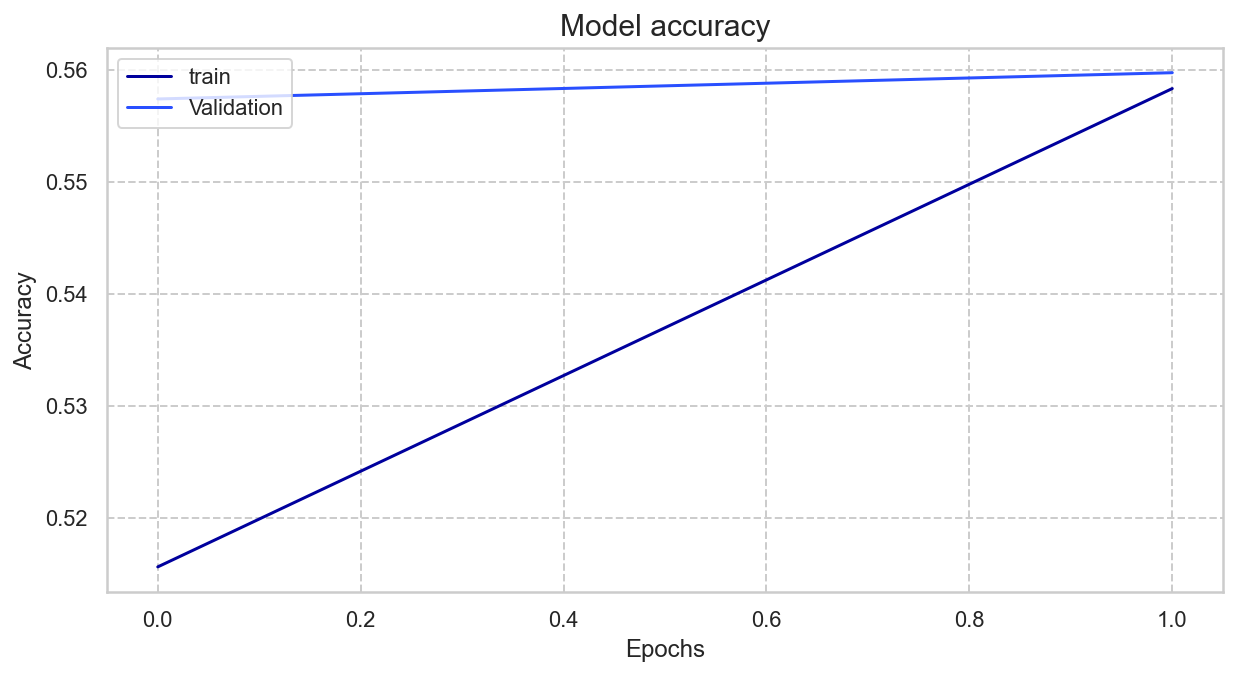

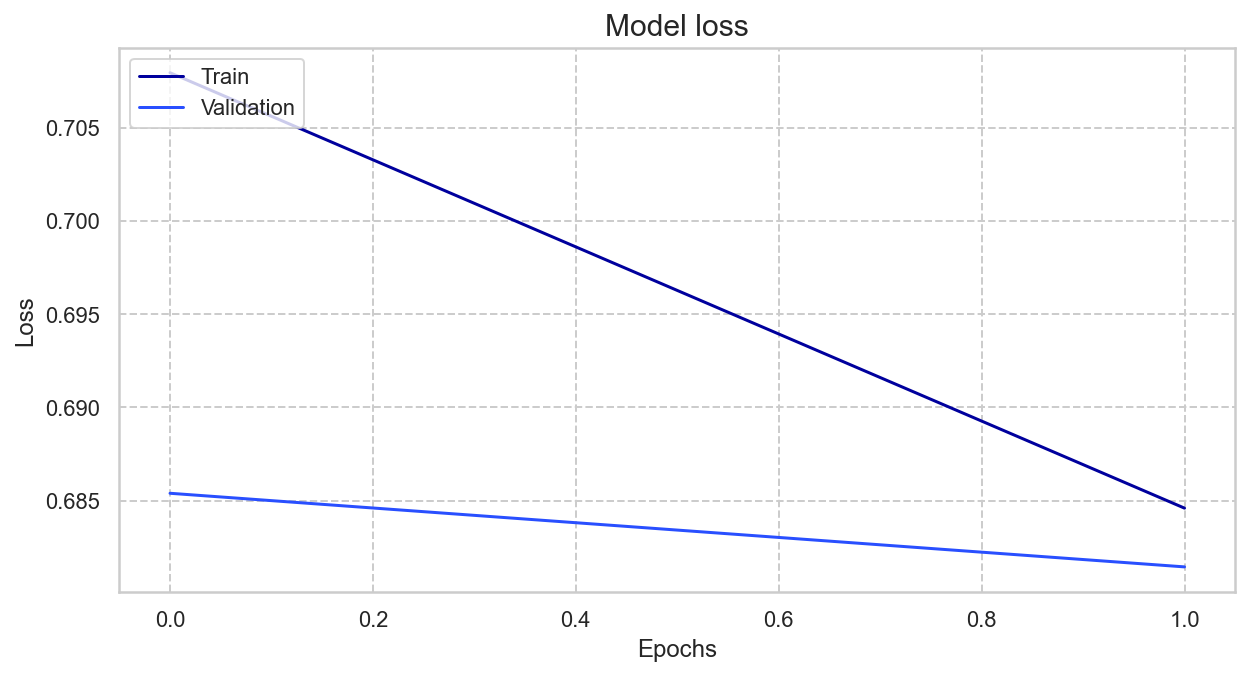

In [40]:
fig1, axs1, fig2, axs2 = utils_adv.plot_history_data(history_load)

In [41]:
# CREDIT DATA
credit_df = pd.DataFrame() # begin empty
rx1, ty1, ik1, oe1, du1 = utils.credit_data_reader()
credit_df['rx1'] = rx1['RX1 Comdty']
credit_df['du1'] = du1['DU1 Comdty']

# CRYPTO DATA
ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"]
crypto_df = utils_adv.crypto_data_reader(ratios)

# set dataset                              
dataset_df = crypto_df                      # --VAR CHANGE 

val_df = utils_adv.split(dataset_df)[1]
df_rpp = utils_adv.get_rpp(val_df, SEQ_LEN+1, ASSET_TO_PREDICT, model_load)

1/1 [==============================] - 1s 917ms/step
61
1/1 [==============================] - 0s 23ms/step
62
1/1 [==============================] - 0s 22ms/step
63
1/1 [==============================] - 0s 21ms/step
64
1/1 [==============================] - 0s 22ms/step
65
1/1 [==============================] - 0s 22ms/step
66
1/1 [==============================] - 0s 21ms/step
67
1/1 [==============================] - 0s 22ms/step
68
1/1 [==============================] - 0s 22ms/step
69
1/1 [==============================] - 0s 23ms/step
70
1/1 [==============================] - 0s 20ms/step
71
1/1 [==============================] - 0s 21ms/step
72
1/1 [==============================] - 0s 22ms/step
73
1/1 [==============================] - 0s 21ms/step
74
1/1 [==============================] - 0s 21ms/step
75
1/1 [==============================] - 0s 22ms/step
76
1/1 [==============================] - 0s 23ms/step
77
1/1 [==============================] - 0s 23ms/step
78
1/1 [====

Mean:  0.48413506
TP: 2916
FP: 1569
TN: 1876
FN: 3349
Precision: 65.02%
Recall: 46.54%


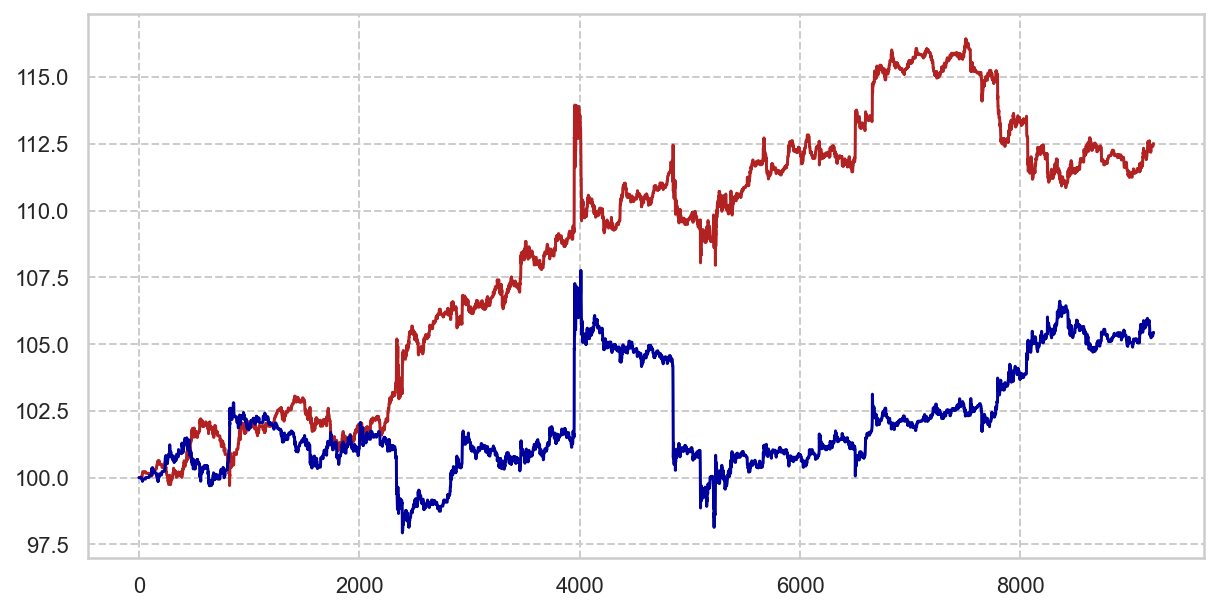

In [179]:
n = 500
first_n_predictions = df_rpp.loc[0:n, 'pred[0]']
mean = np.mean(first_n_predictions)
print('Mean: ', mean)

treshhold = mean +0.000 # 0 = always short, 1 = always long. mean ~ 50/50 short/long
copy_df = df_rpp[n:].reset_index(drop=True)
portfolio_value_trading = utils_adv.get_portfolio_value_trading(copy_df, treshhold)
portfolio_value_hold = utils_adv.get_portfolio_value_hold(copy_df)

# mean_pred = np.mean(pred_list)
# mean_pred
fig, axs = plt.subplots(1,1, figsize=(10,5))
fig = plt.plot(portfolio_value_trading, color='firebrick', linestyle='-')
fig = plt.plot(portfolio_value_hold)

tp, fp, tn, fn = utils_adv.get_statistics_trading(df_rpp, treshhold)
print(f'TP: {tp}')
print(f'FP: {fp}')
print(f'TN: {tn}')
print(f'FN: {fn}')

precision = tp / (tp + fp) #of the positive predictions, how many are correct?
recall = tp / (tp + fn) #how many of the positives did we recall?
print("Precision: {:5.2f}%".format(100 * precision))
print("Recall: {:5.2f}%".format(100 * recall))

In [146]:
correlation = np.corrcoef(portfolio_value_trading, portfolio_value_hold)[1][0]
print("Correlation: {:5.2f}%".format(100 * correlation))

Correlation: 44.42%


In [215]:
returns_hold = utils_adv.get_daily_returns(portfolio_value_hold)
sharpe_hold = utils_adv.sharpe_ratio(returns_hold, 1440*365, 0.02)
sortino_hold = utils_adv.sortino_ratio(returns_hold, 1440*365, 0.02)
print("Sharpe-ratio, hold: {:5.2f}".format(sharpe_hold))
print("Sortino-ratio, hold: {:5.2f}".format(sortino_hold))
gross_return_hold = utils_adv.get_gross_return(portfolio_value_hold)
print("Gross return, hold: {:5.2f}%".format(100 * gross_return_hold))
print('')

returns_trading = utils_adv.get_daily_returns(portfolio_value_trading)
sharpe_trading = utils_adv.sharpe_ratio(returns_trading, 1440*365, 0.02)
sortino_trading = utils_adv.sortino_ratio(returns_trading, 1440*365, 0.02)
print("Sharpe-ratio, trading: {:5.2f}".format(sharpe_trading))
print("Sortino-ratio, trading: {:5.2f}".format(sortino_trading))
gross_return_trading = utils_adv.get_gross_return(portfolio_value_trading)
print("Gross return, trading: {:5.2f}%".format(100 * gross_return_trading))

Sharpe-ratio, hold:  5.31
Sortino-ratio, hold:  5.53
Gross return, hold:  5.44%

Sharpe-ratio, trading: 11.49
Sortino-ratio, trading: 11.95
Gross return, trading: 12.50%


0.1250176374915469